In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 5\. 연습: 2 이진분류: 유방암 데이터 셋 pytorch로 구현

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

In [3]:
breast = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(breast['data'],
                                                    breast['target'],
                                                    test_size=0.2,
                                                    random_state=0)

X_train.shape, X_test.shape

((455, 30), (114, 30))

In [4]:
# scailing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# 파이토치 임포트
import torch

In [6]:
# set data
X_train_scaled_torch = torch.tensor(X_train_scaled, dtype=torch.float)
y_train_torch = torch.tensor(y_train, dtype=torch.float)

X_test_scaled_torch = torch.tensor(X_test_scaled, dtype=torch.float)
y_test_torch = torch.tensor(y_test, dtype=torch.float)

In [88]:
X_train.shape, X_test.shape

((455, 30), (114, 30))

In [161]:
# make model
# 입력 길이는 30, 출력 길이는 1로 가는 시퀀셜 모델
# 마지막 레어어는 2진분류이므로 torch.nn.Sigmoid()
model = torch.nn.Sequential(
    torch.nn.Linear(30, 128), # 관행적으로 128, 256...으로 생성
    torch.nn.ReLU(),

    torch.nn.Linear(128, 32),
    torch.nn.ReLU(),

    torch.nn.Linear(32, 1),
    torch.nn.Sigmoid() # 0 ~ 1
)

In [162]:
list(model.parameters())[0].shape, list(model.parameters())[1].shape

(torch.Size([128, 30]), torch.Size([128]))

In [163]:
# optimizer and loss
# optimizer: Adam, lr=0.001
optimizer =torch.optim.Adam(model.parameters(), lr=0.001)

# loss: BCELoss()
criterion = torch.nn.BCELoss()

In [164]:
# train function
# model을 학습시키기 위한 함수
def train_model(model, X, y, loss_fn, optimizer,
                X_valid=None, y_valid=None,
                batch_size=32,
                max_iter=50):
    history = {
        'loss':[], 'val_loss':[],
        'accuracy':[], 'val_accuracy':[]
    }

    N = X.shape[0]

    # 전체 에폭에 대한 루프
    for i in range(max_iter):
        output = ""
        idx = np.arange(N)
        np.random.shuffle(idx)

        # 한 에폭에서 train 데이터에 대한 루프
        # 한번에 batch_size 만큼 데이터를 가져옴
        for j in range(0, N, batch_size):
            # get mini_batch
            X_batched = X[idx[j:j+batch_size]]
            y_batched = y[idx[j:j+batch_size]]

            # 최적화 5 스탭 순서
            # zero grad->network func.->loss func.->loss backward->step[+]
            optimizer.zero_grad()
            y_pred = model(X_batched)
            # [주의] 모델의 출력은 (N,1), y는 (N,)
            # BCELoss()는 두 텐서의 모양이 일치해야 하기 때문에
            # 모양을 일치시키기위해 모델의 출력을 squeeze() 해야 함
            loss = loss_fn(y_pred.squeeze(), y_batched) # [주의] pred가 앞이고 truth가 뒤
            loss.backward()
            optimizer.step()

        # 한 에폭이 끝난 후 여기서 모델을 평가
        # 이 with문 안에서 그래디언트 추적을 멈춤
        with torch.no_grad():
            # train 데이터에 대해서
            # train loss를 저장
            # [주의] 모델의 출력은 (N,1), y는 (N,) 이므로
            # 두 텐서의 모양을 일치시키기위해 squeeze() 해야 함
            y_pred = model(X).squeeze()
            history['loss'].append( loss_fn(y_pred, y).item() )

            # train accuracy를 저장
            # 모델의 출력 y_pred는 torch.nn.Sigmoid()를 거쳐 출력 되었으므로
            # 0~1사이 값을 가지고 있음
            # 0.5를 임계값으로 해서 0.5이상이면 예측을 1로 만들고 아니면 0으로
            predicted = (y_pred >= 0.5).type(torch.float)
            correct = (predicted == y).sum().item()
            history['accuracy'].append(correct / X.shape[0])

            # train 데이터에 대한 보고 문장
            output += f"Epoch {i+1:{len(str(max_iter))}}/{max_iter} - loss: {history['loss'][-1]:.4f} - accuracy: {history['accuracy'][-1]:.4f}"

            # valid 데이터에 대해서
            # 위 train데이터에 대한 코드와 동일함
            if X_valid != None and y_valid != None:
                # valid loss
                y_pred_valid = model(X_valid).squeeze()
                history['val_loss'].append(loss_fn(y_pred_valid, y_valid).item())

                # valid acc.
                predicted = (y_pred_valid >= 0.5).type(torch.float)
                correct = (predicted == y_valid).sum().item()
                history['val_accuracy'].append(correct / X_valid.shape[0])

                # valid 데이터에 대한 보고 문장
                output += f" - val_loss: {history['val_loss'][-1]:.4f} - val_accuracy: {history['val_accuracy'][-1]:.4f}"

        print(output)

    return history


In [165]:
# model fit
hist = train_model(model, X_train_scaled_torch, y_train_torch, criterion, optimizer,
                   X_test_scaled_torch, y_test_torch, batch_size=128, max_iter=100)

Epoch   1/100 - loss: 0.6854 - accuracy: 0.7319 - val_loss: 0.6844 - val_accuracy: 0.7368
Epoch   2/100 - loss: 0.6714 - accuracy: 0.8681 - val_loss: 0.6711 - val_accuracy: 0.8684
Epoch   3/100 - loss: 0.6566 - accuracy: 0.8769 - val_loss: 0.6575 - val_accuracy: 0.8947
Epoch   4/100 - loss: 0.6384 - accuracy: 0.8835 - val_loss: 0.6400 - val_accuracy: 0.8860
Epoch   5/100 - loss: 0.6167 - accuracy: 0.8901 - val_loss: 0.6184 - val_accuracy: 0.8772
Epoch   6/100 - loss: 0.5919 - accuracy: 0.9011 - val_loss: 0.5929 - val_accuracy: 0.9035
Epoch   7/100 - loss: 0.5636 - accuracy: 0.9099 - val_loss: 0.5646 - val_accuracy: 0.9035
Epoch   8/100 - loss: 0.5315 - accuracy: 0.9099 - val_loss: 0.5333 - val_accuracy: 0.9035
Epoch   9/100 - loss: 0.4964 - accuracy: 0.9033 - val_loss: 0.4997 - val_accuracy: 0.8947
Epoch  10/100 - loss: 0.4589 - accuracy: 0.9077 - val_loss: 0.4619 - val_accuracy: 0.8947
Epoch  11/100 - loss: 0.4208 - accuracy: 0.9121 - val_loss: 0.4226 - val_accuracy: 0.8772
Epoch  12/

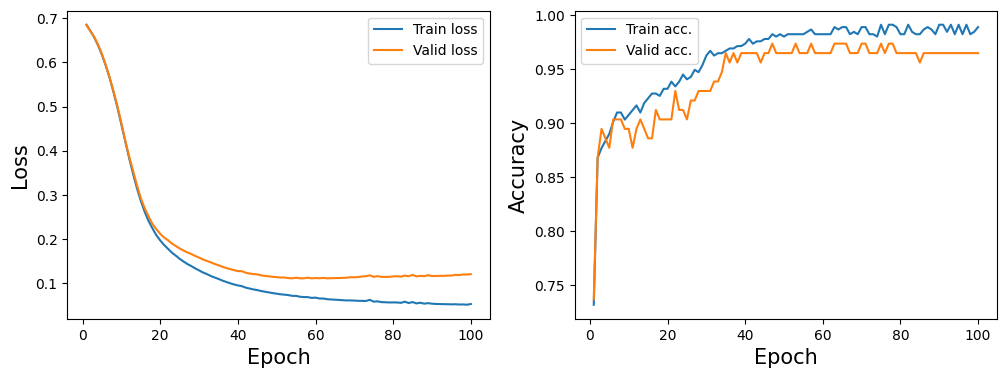

In [166]:
# 학습과정 시각화
# 로스,  정확도 시각화

x = np.linspace(1, len(hist['loss']), len(hist['loss']))
fig, ax = plt.subplots(figsize=(12,4), nrows=1, ncols=2)

ax[0].plot(x, hist['loss'], label='Train loss')
ax[0].plot(x, hist['val_loss'], label='Valid loss')
ax[0].set_xlabel('Epoch', size=15)
ax[0].set_ylabel('Loss', size=15)
ax[0].legend()

ax[1].plot(x, hist['accuracy'], label='Train acc.')
ax[1].plot(x, hist['val_accuracy'], label='Valid acc.')
ax[1].set_xlabel('Epoch', size=15)
ax[1].set_ylabel('Accuracy', size=15)
ax[1].legend()

plt.show()

# 5\. 연습: 3 회귀: 보스톤 집값 데이터 셋 pytorch 로 구현

In [171]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

boston = {'data':data, 'target':target}

X_train, X_test, y_train, y_test = train_test_split(
    boston['data'], boston['target'], random_state=0
)

X_train.shape, X_test.shape

((379, 13), (127, 13))

In [172]:
# scailing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [173]:
# set data
X_train_scaled_torch = torch.tensor(X_train_scaled, dtype=torch.float)
y_train_torch = torch.tensor(y_train, dtype=torch.float)

X_test_scaled_torch = torch.tensor(X_test_scaled, dtype=torch.float)
y_test_torch = torch.tensor(y_test, dtype=torch.float)

In [179]:
# make model
# 입력 길이는 13, 출력 길이는 1로 가는 시퀀셜 모델
# 회귀 모델이므로 마지막 레어어는 그냥 Linear()로 마무리
model = torch.nn.Sequential(

    torch.nn.Linear(13, 64),
    torch.nn.ReLU(),

    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),

    torch.nn.Linear(32, 1),
)

In [180]:
# optimizer and loss
# optimizer: Adam, lr=0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# loss: MSELoss()
criterion = torch.nn.MSELoss()
# BCELoss() : y = 0 or 1일경우..

In [181]:
# 회귀 모델에 대한 평가 지표로 accuracy를 쓸 수 없으므로
# 평가 지표로 쓸 mean_absolute_error, r2_score를 사이킷 런으로 부터 임포트
# 이런 매트릭을 직접 만들어도 되고 파이토치에서 제공하는 것을 사용해도 됨
# 파이토치에서 mean_absolute_error는 L1Loss로 제공하나
# r2_score는 제공하지 않기 때문에 통일성을 위해 두 매트릭 모두 사이킷 런의 api를 빌려 씀
# 사이킷 런과는 넘파이 수준에서 호환되므로 상관 없음
from sklearn.metrics import mean_absolute_error, r2_score

- loss로 accuracy, r2_score를 사용하지 않는 이유
  - accuracy, r2_score의 경우 미분 불가..
  - 미분가능하고 손실을 전달하기 쉬운 MSE 사용

In [182]:
# train function

# model을 학습시키기 위한 함수
def train_model(model, X, y, loss_fn, optimizer,
                X_valid=None, y_valid=None,
                batch_size=32,
                max_iter=50):
    history = {
        'loss': [], 'val_loss': [],
        'mae': [], 'val_mae': [],
        'r_squared': [], 'val_r_squared': []
    }

    N = X.shape[0]

    for i in range(max_iter):
        output = ""
        idx = np.arange(N)
        np.random.shuffle(idx)

        for j in range(0, N, batch_size):
            # get mini_batch
            X_batched = X[idx[j:j+batch_size]]
            y_batched = y[idx[j:j+batch_size]]

            # 최적화 5 스탭 순서
            # zero grad->network func.->loss func.->loss backward->step[+]
            optimizer.zero_grad()
            y_pred = model(X_batched)
            # [주의] 모델의 출력은 (N,1), y는 (N,) 이므로
            # 두 텐서의 모양을 일치시키기위해 squeeze() 해야 함
            loss = loss_fn(y_pred.squeeze(), y_batched) # [주의] pred가 앞이고 truth가 뒤
            loss.backward()
            optimizer.step()

        # 한 에폭이 끝난 후 여기서 모델을 평가
        with torch.no_grad():
            # train
            # train loss
            # [주의] 모델의 출력은 (N,1), y는 (N,) 이므로
            # 두 텐서의 모양을 일치시키기위해 squeeze() 해야 함
            y_pred = model(X).squeeze()
            history['loss'].append( loss_fn(y_pred, y).item() )

            # train mse, r2
            # 앞서 임포트해둔 사이킷런 함수를 이용해 매트릭을 계산하고 저장
            mae = mean_absolute_error(y.numpy(), y_pred.numpy())
            r2 = r2_score(y.numpy(), y_pred.numpy())
            history['mae'].append(mae)
            history['r_squared'].append(r2)

            # train 데이터에 대한 보고 문장
            output += f"Epoch {i+1:{len(str(max_iter))}}/{max_iter} - loss: {history['loss'][-1]:.4f} - mae: {history['mae'][-1]:.4f} -  r2: {history['r_squared'][-1]:.4f}"

            # valid
            if X_valid != None and y_valid != None:
                # valid loss
                y_pred_valid = model(X_valid).squeeze()
                history['val_loss'].append(loss_fn(y_pred_valid, y_valid).item())

                # valid mse, r2
                mae = mean_absolute_error(y_valid.numpy(), y_pred_valid.numpy())
                r2 = r2_score(y_valid.numpy(), y_pred_valid.numpy())
                history['val_mae'].append(mae)
                history['val_r_squared'].append(r2)

                # valid 데이터에 대한 보고 문장
                output += f" - val_loss: {history['val_loss'][-1]:.4f} - val_mae: {history['val_mae'][-1]:.4f} - val_r2: {history['val_r_squared'][-1]:.4f}"

        print(output)

    return history


In [183]:
# model fit
hist = train_model(model, X_train_scaled_torch, y_train_torch, criterion, optimizer,
                   X_test_scaled_torch, y_test_torch, batch_size=128, max_iter=1000)

Epoch    1/1000 - loss: 597.3176 - mae: 22.6186 -  r2: -6.0019 - val_loss: 579.6804 - val_mae: 22.3083 - val_r2: -6.0953
Epoch    2/1000 - loss: 593.2314 - mae: 22.5256 -  r2: -5.9540 - val_loss: 575.6151 - val_mae: 22.2156 - val_r2: -6.0456
Epoch    3/1000 - loss: 589.1436 - mae: 22.4325 -  r2: -5.9061 - val_loss: 571.5493 - val_mae: 22.1224 - val_r2: -5.9958
Epoch    4/1000 - loss: 584.9059 - mae: 22.3352 -  r2: -5.8564 - val_loss: 567.3047 - val_mae: 22.0246 - val_r2: -5.9438
Epoch    5/1000 - loss: 580.3588 - mae: 22.2298 -  r2: -5.8031 - val_loss: 562.7214 - val_mae: 21.9179 - val_r2: -5.8877
Epoch    6/1000 - loss: 575.3574 - mae: 22.1132 -  r2: -5.7445 - val_loss: 557.6661 - val_mae: 21.7997 - val_r2: -5.8259
Epoch    7/1000 - loss: 569.7635 - mae: 21.9819 -  r2: -5.6789 - val_loss: 552.0751 - val_mae: 21.6680 - val_r2: -5.7574
Epoch    8/1000 - loss: 563.4996 - mae: 21.8348 -  r2: -5.6055 - val_loss: 545.8411 - val_mae: 21.5208 - val_r2: -5.6811
Epoch    9/1000 - loss: 556.4572

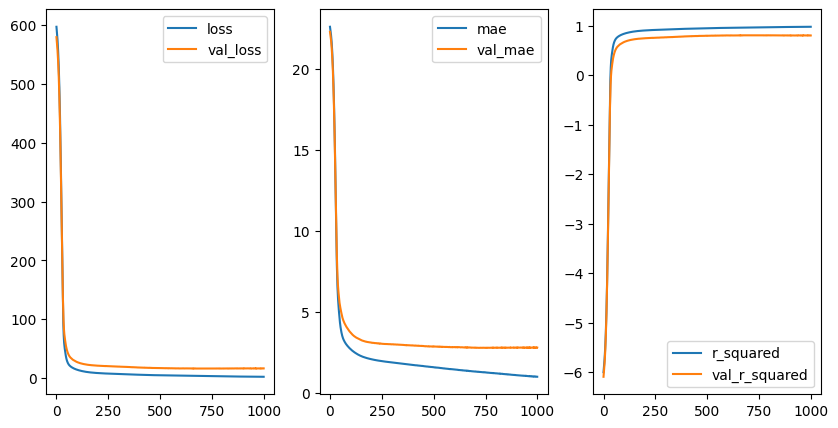

In [184]:
# history plot
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(10,5), nrows=1, ncols=3)

axs[0].plot(hist['loss'], label='loss')
axs[0].plot(hist['val_loss'], label='val_loss')
axs[0].legend()

axs[1].plot(hist['mae'], label='mae')
axs[1].plot(hist['val_mae'], label='val_mae')
axs[1].legend()

axs[2].plot(hist['r_squared'], label='r_squared')
axs[2].plot(hist['val_r_squared'], label='val_r_squared')
axs[2].legend()

plt.show()

# 5\. 연습: 4 다클래스 분류: fashion mnist

In [185]:
!gdown  1lo-tPwidDyA9uAOUbCkpHetwEuiBxcyp
!unzip fashion-mnist-csv.zip

Downloading...
From (original): https://drive.google.com/uc?id=1lo-tPwidDyA9uAOUbCkpHetwEuiBxcyp
From (redirected): https://drive.google.com/uc?id=1lo-tPwidDyA9uAOUbCkpHetwEuiBxcyp&confirm=t&uuid=ce58a4db-90c4-426f-b59a-5b7bb596ed7e
To: /content/fashion-mnist-csv.zip
100% 36.3M/36.3M [00:01<00:00, 33.4MB/s]
Archive:  fashion-mnist-csv.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  


In [186]:
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

In [187]:
train_data.shape, test_data.shape

((60000, 785), (10000, 785))

In [188]:
# label 정의

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Sample shape: (784,) label: 9


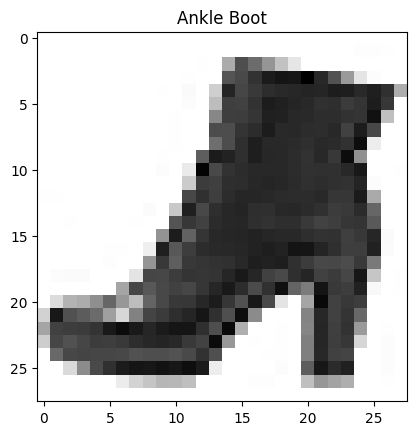

In [189]:
# 데이터 확인
idx = np.random.choice(len(train_data), 1)

X = train_data.loc[idx[0]][1:].to_numpy()
y = train_data.loc[idx[0]][0]
print("Sample shape:", X.shape, "label:", y)

# 이미지 확인
fig = plt.figure()
ax = plt.axes()

ax.imshow(X.reshape(28,28), cmap='binary')
ax.set_title(labels_map[y])
plt.show()

In [190]:
X_train = train_data.iloc[:,1:] # dataframe
y_train = train_data.iloc[:,0]  # series

X_test = test_data.iloc[:,1:] # dataframe
y_test = test_data.iloc[:,0]  # series

In [191]:
# 픽셀당 최소 최대값 확인
X_train.iloc[0].min(), X_train.iloc[0].max()

(0, 255)

In [192]:
# normalize
X_train_scaled = (X_train / 255).to_numpy()
X_test_scaled = (X_test / 255).to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [193]:
# set data
X_train_scaled_torch = torch.tensor(X_train_scaled, dtype=torch.float)
y_train_torch = torch.tensor(y_train, dtype=torch.long)

X_test_scaled_torch = torch.tensor(X_test_scaled, dtype=torch.float)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

In [201]:
# model
# 입력 길이는 784, 출력 길이는 10인 모델
# 10 클래스 분류 모델, 활서함수 torch.nn.ReLU() 사용
# 마지막 레어어는 그냥 torch.nn.Linear()로 마무리
model = torch.nn.Sequential(

    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),

    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),

    torch.nn.Linear(128, 10)
    # 분류이지만 Linear로 끝나는 이유는 아래에 설명
)

In [202]:
# optimizer and loss[+]

# optimizer: Adam, lr=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# loss: CrossEntropyLoss()
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# 이 손실함수는 입력으로 Linear()에서 출력된 로짓logit을 입력받아
# 내부에서 소프트맥스와 로그함수를 적용함
# 그래서 모델 정의에서 마지막을 Linear()로 끝나게 만들었음
criterion = torch.nn.CrossEntropyLoss()

In [203]:
# train function
# model을 학습시키기 위한 함수
def train_model(model, X, y, loss_fn, optimizer,
                X_valid=None, y_valid=None,
                batch_size=32,
                max_iter=50):
    history = {
        'loss':[], 'val_loss':[],
        'accuracy':[], 'val_accuracy':[]
    }

    N = X.shape[0]

    for i in range(max_iter):
        output = ""
        idx = np.arange(N)
        np.random.shuffle(idx)

        for j in range(0, N, batch_size):
            # get mini_batch
            X_batched = X[idx[j:j+batch_size]]
            y_batched = y[idx[j:j+batch_size]]

            # 최적화 5 스탭 순서
            # zero grad->network func.->loss func.->loss backward->step[+]
            optimizer.zero_grad()
            y_pred = model(X_batched)
            # [주의] 모델의 출력은 (N,C), y는 (N,) 인데
            # CrossEntropyLoss에 그대로 입력하면 됨
            loss = loss_fn(y_pred, y_batched) # [주의] pred가 앞이고 truth가 뒤
            loss.backward()
            optimizer.step()

        # 한 에폭이 끝난 후 여기서 모델을 평가
        with torch.no_grad():
            # train
            # train loss
            # [주의] 모델의 출력은 (N,C), y는 (N,)
            # 여기서는 그대로 입력
            y_pred = model(X)
            history['loss'].append( loss_fn(y_pred, y).item() )

            # train acc.
            predicted = torch.argmax(y_pred, axis=1)
            correct = (predicted == y).sum().item()
            history['accuracy'].append(correct / X.shape[0])

            # train 데이터에 대한 보고 문장
            output += f"Epoch {i+1:{len(str(max_iter))}}/{max_iter} - loss: {history['loss'][-1]:.4f} - accuracy: {history['accuracy'][-1]:.4f}"

            # valid
            if X_valid != None and y_valid != None:
                # valid loss
                y_pred_valid = model(X_valid)
                history['val_loss'].append( loss_fn(y_pred_valid, y_valid).item() )

                # valid acc.
                predicted = torch.argmax(y_pred_valid, axis=1)
                correct = (predicted == y_valid).sum().item()
                history['val_accuracy'].append(correct / X_valid.shape[0])

                # valid 데이터에 대한 보고 문장
                output += f" - val_loss: {history['val_loss'][-1]:.4f} - val_accuracy: {history['val_accuracy'][-1]:.4f}"

        print(output)

    return history


In [204]:
# model fit
hist = train_model(model, X_train_scaled_torch, y_train_torch, criterion, optimizer,
                   X_test_scaled_torch, y_test_torch, batch_size=32, max_iter=30)

Epoch  1/30 - loss: 0.4571 - accuracy: 0.8406 - val_loss: 0.4748 - val_accuracy: 0.8378
Epoch  2/30 - loss: 0.4085 - accuracy: 0.8518 - val_loss: 0.4248 - val_accuracy: 0.8476
Epoch  3/30 - loss: 0.5572 - accuracy: 0.8056 - val_loss: 0.5722 - val_accuracy: 0.8067
Epoch  4/30 - loss: 0.4345 - accuracy: 0.8419 - val_loss: 0.4648 - val_accuracy: 0.8368
Epoch  5/30 - loss: 0.4369 - accuracy: 0.8484 - val_loss: 0.4782 - val_accuracy: 0.8395
Epoch  6/30 - loss: 0.3666 - accuracy: 0.8628 - val_loss: 0.4012 - val_accuracy: 0.8543
Epoch  7/30 - loss: 0.3855 - accuracy: 0.8608 - val_loss: 0.4308 - val_accuracy: 0.8545
Epoch  8/30 - loss: 0.3486 - accuracy: 0.8720 - val_loss: 0.3845 - val_accuracy: 0.8647
Epoch  9/30 - loss: 0.3686 - accuracy: 0.8642 - val_loss: 0.4283 - val_accuracy: 0.8533
Epoch 10/30 - loss: 0.3841 - accuracy: 0.8576 - val_loss: 0.4301 - val_accuracy: 0.8512
Epoch 11/30 - loss: 0.3734 - accuracy: 0.8689 - val_loss: 0.4356 - val_accuracy: 0.8592
Epoch 12/30 - loss: 0.3597 - acc

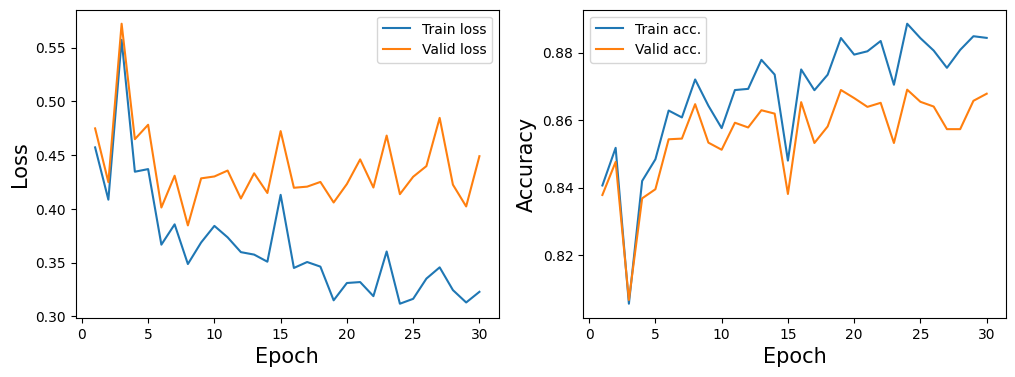

In [205]:
# 학습과정 시각화
# 로스,  정확도 시각화

x = np.linspace(1, len(hist['loss']), len(hist['loss']))
fig, ax = plt.subplots(figsize=(12,4), nrows=1, ncols=2)

ax[0].plot(x, hist['loss'], label='Train loss')
ax[0].plot(x, hist['val_loss'], label='Valid loss')
ax[0].set_xlabel('Epoch', size=15)
ax[0].set_ylabel('Loss', size=15)
ax[0].legend()

ax[1].plot(x, hist['accuracy'], label='Train acc.')
ax[1].plot(x, hist['val_accuracy'], label='Valid acc.')
ax[1].set_xlabel('Epoch', size=15)
ax[1].set_ylabel('Accuracy', size=15)
ax[1].legend()

plt.show()

(10000,) (10000,)


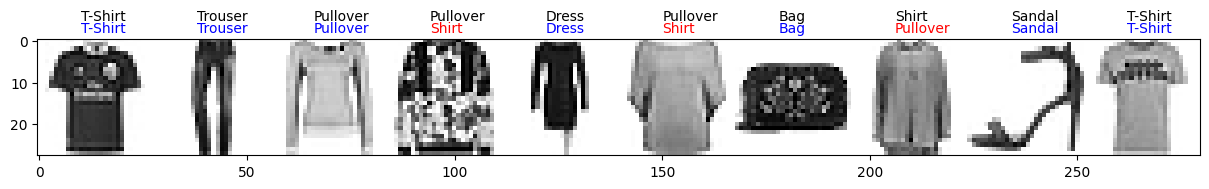

Accucary: 0.8678


In [206]:
pred = model(X_test_scaled_torch)
pred = torch.argmax(pred, axis=1).numpy()
print(pred.shape, y_test.shape)
acc = (y_test == pred).astype(int).sum() / y_test.shape[0]

fig = plt.figure(figsize=(15,7), dpi=100)
ax = plt.axes()

ax.imshow(X_test_scaled[0:10].reshape(10,28,28).transpose(1,0,2).reshape(28,-1),
          cmap='binary')

for i in range(10):
    ax.text(i*28+10, -5, labels_map[y_test[i]])
    ax.text(i*28+10, -2, labels_map[pred[i]], color='b'
            if labels_map[y_test[i]]==labels_map[pred[i]] else 'r')

plt.show()

print(f'Accucary: {acc}')

